In [169]:
import torch
from torch.utils.data import Dataset, DataLoader , random_split
import math

class NormalizedSinDataset(Dataset):
    def __init__(self, n_samples=2000, noise_std=0.1, physical_range=(0, 3.14)): # Réduit à Pi pour commencer
        super().__init__()
        
        # 1. Génération dans l'espace physique (Le "Vrai Monde")
        # On réduit un peu la range car sin(xy) oscille trop vite vers 2pi
        low, high = physical_range
        self.x_phys = torch.rand(n_samples, 1) * (high - low) + low
        self.y_phys = torch.rand(n_samples, 1) * (high - low) + low
        
        # 2. Calcul de la cible physique
        noise = noise_std * torch.randn(n_samples, 1)
        self.z = torch.sin(self.x_phys * self.y_phys) * torch.cos(self.x_phys - self.y_phys) + noise
        
        # 3. NORMALISATION pour le Réseau (Crucial pour DSN)
        # On mappe [low, high] vers [-1, 1]
        # Formule : 2 * (x - min) / (max - min) - 1
        self.x_norm = 2 * (self.x_phys - low) / (high - low) - 1
        self.y_norm = 2 * (self.y_phys - low) / (high - low) - 1

    def __len__(self):
        return len(self.x_phys)

    def __getitem__(self, idx):
        # Le réseau voit les données normalisées [-1, 1]
        X = torch.cat([self.x_norm[idx], self.y_norm[idx]], dim=0) 
        return X, self.z[idx]

# Configuration recommandée pour l'explicabilité
dataset = NormalizedSinDataset(
    n_samples=5000,       # Un peu plus de points pour capturer les oscillations
    noise_std=0.10,       # Un peu moins de bruit pour aider SymPy
    physical_range=(0, 3.14) # On reste sur [0, Pi] pour éviter l'explosion fréquentielle
)

train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False
)

In [148]:
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

class MLP(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)
        
def init_weights(m):
    # Applique l'initialisation orthogonale aux couches Linéaires
    if isinstance(m, nn.Linear):
        # Gain calculé pour compenser la non-linéarité (ici on suppose ReLU ou quadratique)
        nn.init.orthogonal_(m.weight, gain=1.414)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
        
def train(model, train_loader, test_loader, epochs=200):
    for epoch in range(epochs):

        # ===== TRAIN =====
        model.train()
        train_loss = 0.0
        y_true_train, y_pred_train = [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            y_true_train.append(y.detach().cpu())
            y_pred_train.append(pred.detach().cpu())

        train_loss /= len(train_loader.dataset)

        train_r2 = r2_score(
            torch.cat(y_true_train).numpy(),
            torch.cat(y_pred_train).numpy()
        )

        # ===== TEST =====
        model.eval()
        test_loss = 0.0
        y_true_test, y_pred_test = [], []

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)

                test_loss += loss.item() * x.size(0)
                y_true_test.append(y.cpu())
                y_pred_test.append(pred.cpu())

        test_loss /= len(test_loader.dataset)
        scheduler.step(test_loss)
        test_r2 = r2_score(
            torch.cat(y_true_test).numpy(),
            torch.cat(y_pred_test).numpy()
        )

        # ===== LOG =====
        if epoch % 20 == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch:03d} | "
                f"Train MSE: {train_loss:.5f} | Test MSE: {test_loss:.5f} | "
                f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f} |"
                f"LR : {optimizer.param_groups[0]['lr']}"
            )

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [174]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(hidden_dim=32).to(device)
model.apply(init_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
print(count_parameters(model))

(1185, 1185)


In [175]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [176]:
train(model, train_loader, test_loader, epochs=1600)

Epoch 000 | Train MSE: 0.21362 | Test MSE: 0.21233 | Train R²: 0.0611 | Test R²: 0.0750 |LR : 0.001
Epoch 020 | Train MSE: 0.04635 | Test MSE: 0.04248 | Train R²: 0.7963 | Test R²: 0.8149 |LR : 0.001
Epoch 040 | Train MSE: 0.03172 | Test MSE: 0.02700 | Train R²: 0.8606 | Test R²: 0.8824 |LR : 0.001
Epoch 060 | Train MSE: 0.02902 | Test MSE: 0.02522 | Train R²: 0.8725 | Test R²: 0.8901 |LR : 0.001
Epoch 080 | Train MSE: 0.02729 | Test MSE: 0.02333 | Train R²: 0.8801 | Test R²: 0.8984 |LR : 0.001
Epoch 100 | Train MSE: 0.02576 | Test MSE: 0.02220 | Train R²: 0.8868 | Test R²: 0.9033 |LR : 0.001
Epoch 120 | Train MSE: 0.02347 | Test MSE: 0.02130 | Train R²: 0.8968 | Test R²: 0.9072 |LR : 0.001
Epoch 140 | Train MSE: 0.02139 | Test MSE: 0.01971 | Train R²: 0.9060 | Test R²: 0.9141 |LR : 0.001
Epoch 160 | Train MSE: 0.01915 | Test MSE: 0.01765 | Train R²: 0.9158 | Test R²: 0.9231 |LR : 0.001
Epoch 180 | Train MSE: 0.01723 | Test MSE: 0.01641 | Train R²: 0.9243 | Test R²: 0.9285 |LR : 0.001


KeyboardInterrupt: 

In [99]:
def lsuv_init(model, loader, device):
    model.eval()
    # On prend un batch de données
    x, y = next(iter(loader))
    x = x.to(device)
    
    print("🔧 Calibration LSUV en cours...")
    
    # On parcourt chaque couche
    for name, layer in model.named_modules():
        # On ne touche qu'aux couches qui ont des poids (Linear, Conv, Spectral)
        if isinstance(layer, (nn.Linear, nn.Conv2d)) or hasattr(layer, 'proj'):
            
            # 1. On calcule la sortie actuelle
            with torch.no_grad():
                out = layer(x) # Si ça plante ici, il faut adapter à ton forward
            
            # 2. On mesure la variance
            var = out.var()
            if var < 1e-6: continue # Évite la division par zéro
            
            # 3. On force la variance à 1.0 en redimensionnant les poids
            scale = 1.0 / var.sqrt()
            
            if hasattr(layer, 'weight'):
                layer.weight.data *= scale
            elif hasattr(layer, 'proj'): # Pour ton bloc spectral
                layer.proj.weight.data *= scale
            
            print(f"   -> Couche {name} recalibrée (Scale: {scale:.2f})")
            
            # On met à jour x pour la couche suivante
            x = out

    print("✅ Calibration terminée. Le modèle est prêt.")
    return model

In [149]:
def lsuv_init(model, loader, device, needed_std=1.0):
    model.eval()
    model.to(device)
    
    # On récupère un seul batch pour la calibration
    batch = next(iter(loader))[0].to(device)
    
    print(f"🔧 Démarrage calibration LSUV (Cible STD: {needed_std})...")
    
    # On liste toutes les couches qui ont des poids
    layers_to_scale = [m for m in model.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
    
    with torch.no_grad():
        for i, layer in enumerate(layers_to_scale):
            
            # --- Étape 1 : Mesurer ---
            # On place un "espion" (hook) sur la couche actuelle
            activation_stats = {}
            def hook_fn(module, inp, out):
                activation_stats['std'] = out.std().item()
            
            handle = layer.register_forward_hook(hook_fn)
            
            # On fait passer le batch dans TOUT le réseau
            # C'est important : comme ça les blocs résiduels reçoivent les bons inputs
            model(batch)
            
            # On enlève l'espion
            handle.remove()
            
            # --- Étape 2 : Corriger ---
            current_std = activation_stats.get('std', 0.0)
            if current_std < 1e-6:
                continue # Évite la division par zéro (neurone mort)
            
            scaler = needed_std / (current_std + 1e-8)
            
            if hasattr(layer, 'weight') and layer.weight is not None:
                layer.weight.data *= scaler
                # Optionnel : on peut aussi ajuster le bias, mais souvent inutile pour la variance
            
            # Affichage pour vérifier que ça ne diverge pas
            if i % 5 == 0 or scaler > 5.0 or scaler < 0.2:
                print(f"   -> Layer {i}: STD={current_std:.3f} => Scale={scaler:.2f}")

    print("✅ Calibration LSUV terminée.")
    return model

In [170]:
from SBN import SpectralBillinearNet
from QHN import DeepSpectralNet, SpectralQuadraticLayer

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = SpectralBillinearNet([2,16,8,1],use_layernorm = True).to(device)
model = DeepSpectralNet([2,4,8,4,1],ortho_mode='soft',dropout=0,use_residuals=True).to(device)
#model = DeepSpectralNet([2,8,16,8,1],ortho_mode=None).to(device)
model = lsuv_init(model, train_loader,device)
print(count_parameters(model))

🔧 Démarrage calibration LSUV (Cible STD: 1.0)...
   -> Layer 0: STD=1.000 => Scale=1.00
   -> Layer 4: STD=0.145 => Scale=6.90
   -> Layer 5: STD=0.669 => Scale=1.49
   -> Layer 7: STD=0.136 => Scale=7.35
   -> Layer 10: STD=0.078 => Scale=12.76
✅ Calibration LSUV terminée.
(327, 327)


In [179]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00005, momentum=0.9)
criterion = nn.MSELoss()

In [183]:
# 1. Définition de l'optimiseur et du Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-4)

# LE SAUVEUR : Si 'test_loss' ne baisse pas pendant 'patience' époques, on réduit le LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.8,      # On réduit de seulement 20% à chaque fois
    patience=100,    # On attend 100 époques (au lieu de 50)
    min_lr=1e-5,     # INTERDIT de descendre sous 0.00001
)

In [184]:
train(model, train_loader, test_loader, epochs=3200)

Epoch 000 | Train MSE: 0.31622 | Test MSE: 0.20087 | Train R²: -0.3899 | Test R²: 0.1249 |LR : 0.01
Epoch 020 | Train MSE: 0.02343 | Test MSE: 0.01968 | Train R²: 0.8970 | Test R²: 0.9143 |LR : 0.01
Epoch 040 | Train MSE: 0.01736 | Test MSE: 0.01696 | Train R²: 0.9237 | Test R²: 0.9261 |LR : 0.01
Epoch 060 | Train MSE: 0.01473 | Test MSE: 0.01244 | Train R²: 0.9353 | Test R²: 0.9458 |LR : 0.01
Epoch 080 | Train MSE: 0.01487 | Test MSE: 0.01390 | Train R²: 0.9346 | Test R²: 0.9394 |LR : 0.01
Epoch 100 | Train MSE: 0.01468 | Test MSE: 0.01652 | Train R²: 0.9355 | Test R²: 0.9280 |LR : 0.01
Epoch 120 | Train MSE: 0.01192 | Test MSE: 0.01159 | Train R²: 0.9476 | Test R²: 0.9495 |LR : 0.01
Epoch 140 | Train MSE: 0.01210 | Test MSE: 0.01232 | Train R²: 0.9468 | Test R²: 0.9463 |LR : 0.01
Epoch 160 | Train MSE: 0.01215 | Test MSE: 0.01124 | Train R²: 0.9466 | Test R²: 0.9510 |LR : 0.01
Epoch 180 | Train MSE: 0.01319 | Test MSE: 0.01195 | Train R²: 0.9420 | Test R²: 0.9479 |LR : 0.01
Epoch 200

KeyboardInterrupt: 

In [136]:
train(model, train_loader, test_loader, epochs=160)

Epoch 000 | Train MSE: 0.04926 | Test MSE: 0.04270 | Train R²: 0.8184 | Test R²: 0.8297 |LR : 0.001
Epoch 020 | Train MSE: 0.04936 | Test MSE: 0.04334 | Train R²: 0.8180 | Test R²: 0.8272 |LR : 0.001
Epoch 040 | Train MSE: 0.04858 | Test MSE: 0.04240 | Train R²: 0.8209 | Test R²: 0.8309 |LR : 0.001
Epoch 060 | Train MSE: 0.04900 | Test MSE: 0.04366 | Train R²: 0.8193 | Test R²: 0.8259 |LR : 0.001
Epoch 080 | Train MSE: 0.04844 | Test MSE: 0.04204 | Train R²: 0.8214 | Test R²: 0.8324 |LR : 0.001
Epoch 100 | Train MSE: 0.04930 | Test MSE: 0.04414 | Train R²: 0.8182 | Test R²: 0.8240 |LR : 0.001
Epoch 120 | Train MSE: 0.04870 | Test MSE: 0.04222 | Train R²: 0.8204 | Test R²: 0.8317 |LR : 0.001
Epoch 140 | Train MSE: 0.04874 | Test MSE: 0.04214 | Train R²: 0.8203 | Test R²: 0.8320 |LR : 0.001
Epoch 159 | Train MSE: 0.04951 | Test MSE: 0.04260 | Train R²: 0.8175 | Test R²: 0.8301 |LR : 0.001


In [190]:
import torch
import sympy as sp
import numpy as np

def clean_expr(expr, threshold=0.01):
    """Nettoie une expression SymPy en supprimant les petits coefficients."""
    # On expand d'abord pour séparer les termes
    expr = sp.expand(expr)
    
    # On remplace les petits floats par 0
    cleaned = expr.replace(
        lambda x: x.is_Float and abs(x) < threshold, 
        lambda x: 0
    )
    return cleaned

def extract_deep_formula(model, input_names=['x', 'y'], threshold=0.01):
    print(f"🚀 Démarrage de l'extraction profonde (Threshold={threshold})...")
    
    # 1. Variables initiales (Couche 0)
    current_exprs = [sp.symbols(name) for name in input_names]
    
    device = next(model.parameters()).device
    
    # 2. Traversée du réseau couche par couche
    for i, module in enumerate(model.layers):
        print(f"   -> Traitement Layer {i} ({type(module).__name__})...")
        
        # Cas A : SpectralResidualBlock (Le plus probable avec ton code v2)
        if hasattr(module, 'layer'): 
            # 1. Partie Spectrale
            spec_layer = module.layer
            
            # Entrée normalisée (LayerNorm simplifiée par identité pour l'analyse symbolique 
            # car difficile à représenter, ou on assume que les inputs sont centrés réduits)
            # Note: Pour être exact, LayerNorm(x) = (x - mean)/std. 
            # Ici on approxime que le réseau a intégré la norm dans ses poids.
            input_vars = current_exprs 
            
            # --- Calcul Spectral ---
            # a. Changement de base (Linear)
            W = spec_layer.base_change.weight.detach().cpu().numpy()
            b_base = spec_layer.base_change.bias.detach().cpu().numpy() if spec_layer.base_change.bias is not None else None
            
            # Scaling
            scale = spec_layer.scaling_factor if spec_layer.use_scaling else 1.0
            
            hidden_spectral = []
            for out_idx in range(spec_layer.in_features): # Base change conserve la dim
                term = 0
                for in_idx, var in enumerate(input_vars):
                    term += W[out_idx, in_idx] * var
                if b_base is not None:
                    term += b_base[out_idx]
                
                # Scaling + Carré
                hidden_spectral.append((term * scale)**2)
            
            # b. Recombinaison (Eigen Weights)
            V = spec_layer.eigen_weights.weight.detach().cpu().numpy()
            b_eigen = spec_layer.eigen_weights.bias.detach().cpu().numpy() if spec_layer.eigen_weights.bias is not None else None
            
            spectral_out = []
            for out_idx in range(spec_layer.out_features):
                term = 0
                for k in range(len(hidden_spectral)):
                    term += V[out_idx, k] * hidden_spectral[k]
                if b_eigen is not None:
                    term += b_eigen[out_idx]
                spectral_out.append(term)
            
            # 2. Partie Résiduelle (Projection + Gate + Addition)
            # Projection du résiduel si dimensions différentes
            residual_out = []
            if module.needs_projection:
                W_proj = module.projection.weight.detach().cpu().numpy()
                for out_idx in range(spec_layer.out_features):
                    term = 0
                    for in_idx, var in enumerate(current_exprs):
                        term += W_proj[out_idx, in_idx] * var
                    residual_out.append(term)
            else:
                residual_out = current_exprs # Identité
            
            # Gate (res_weight)
            gate = module.res_weight.item() if hasattr(module, 'res_weight') else 1.0
            
            # Somme Finale du Bloc : Residual + Gate * Spectral
            next_exprs = []
            for idx in range(spec_layer.out_features):
                # Formule du bloc
                combined = residual_out[idx] + gate * spectral_out[idx]
                # NETTOYAGE CRITIQUE (Sinon explosion mémoire)
                next_exprs.append(clean_expr(combined, threshold))
            
            current_exprs = next_exprs

        # Cas B : Linear pur (Dernière couche souvent)
        elif isinstance(module, nn.Linear):
            W = module.weight.detach().cpu().numpy()
            b = module.bias.detach().cpu().numpy() if module.bias is not None else None
            
            next_exprs = []
            for out_idx in range(module.out_features):
                term = 0
                for in_idx, var in enumerate(current_exprs):
                    term += W[out_idx, in_idx] * var
                if b is not None:
                    term += b[out_idx]
                next_exprs.append(clean_expr(term, threshold))
            
            current_exprs = next_exprs

    # 3. Résultat Final
    print("\n✅ Formule Finale Extraite :")
    final_formula = current_exprs[0] # On suppose 1 seule sortie
    print(final_formula)
    return final_formula

# --- Lancer l'extraction ---
formula = extract_deep_formula(model, threshold=0.1) # Threshold un peu haut pour commencer et voir les gros termes

🚀 Démarrage de l'extraction profonde (Threshold=0.1)...
   -> Traitement Layer 0 (SpectralResidualBlock)...
   -> Traitement Layer 1 (SpectralResidualBlock)...
   -> Traitement Layer 2 (SpectralResidualBlock)...
   -> Traitement Layer 3 (SpectralResidualBlock)...

✅ Formule Finale Extraite :
0.152957914188869*x**9*y - 0.394992527021558*x**9 + 1.06846057388153*x**8*y**2 - 2.6089794142295*x**8*y + 4.57368767572949*x**8 - 0.340228766952155*x**7*y**4 + 2.91558944964884*x**7*y**3 - 8.35842698363695*x**7*y**2 + 17.6406859817671*x**7*y - 7.25722665122243*x**7 - 0.589898202296714*x**6*y**5 + 4.48008608381319*x**6*y**4 - 15.7380136140686*x**6*y**3 + 34.4207343865102*x**6*y**2 - 31.0298622454691*x**6*y + 6.12799408277444*x**6 - 0.566729449287098*x**5*y**6 + 4.30169736994883*x**5*y**5 - 18.1642449670569*x**5*y**4 + 42.1276781276374*x**5*y**3 - 55.972646525117*x**5*y**2 + 21.4716494675767*x**5*y + 2.09560010410263*x**5 - 0.307277617739853*x**4*y**7 + 2.67170584617077*x**4*y**6 - 13.1062133813575*x

In [186]:
import sympy as sp
import numpy as np
import torch

def simplify_equation_by_impact(formula_str, model, val_loader, feature_names=['x', 'y'], top_k=5):
    """
    Simplifie l'équation en ne gardant que les termes qui ont un réel impact sur la sortie.
    """
    print("🧹 Démarrage de la simplification statistique...")
    
    # 1. Parsing de la formule (long mais nécessaire)
    # On suppose que formula_str est l'expression SymPy brute
    expr = sp.expand(formula_str)
    terms = sp.Add.make_args(expr) # Sépare les monômes (ax^2, bxy...)
    
    # 2. Récupération d'un batch de données
    x_val, y_val = next(iter(val_loader))
    x_np = x_val.cpu().numpy() # Shape (Batch, In_Dim)
    
    # Dictionnaire pour stocker l'impact de chaque terme
    term_impacts = []
    
    print(f"   Analyse de {len(terms)} termes sur {len(x_np)} exemples...")
    
    # 3. Évaluation de chaque terme
    # On crée des lambdas pour aller vite
    x_sym, y_sym = sp.symbols(feature_names[0]), sp.symbols(feature_names[1])
    
    total_variance = 0
    evaluated_terms = []
    
    for term in terms:
        # Convertit le terme symbolique en fonction Python
        func = sp.lambdify((x_sym, y_sym), term, 'numpy')
        
        # Calcule la valeur du terme sur tout le batch
        # Attention: x_np[:,0] est x, x_np[:,1] est y
        values = func(x_np[:, 0], x_np[:, 1])
        
        # L'impact est l'écart-type de ce terme (sa contribution à la variance)
        impact = np.std(values)
        mean_val = np.mean(values)
        
        evaluated_terms.append((term, impact, mean_val))
        total_variance += impact
        
    # 4. Tri et Sélection
    # On trie par impact décroissant
    evaluated_terms.sort(key=lambda x: x[1], reverse=True)
    
    print("\n🏆 Top Termes Dominants :")
    final_expr = 0
    cumulative_impact = 0
    
    for i, (term, impact, mean_val) in enumerate(evaluated_terms[:top_k]):
        rel_impact = (impact / total_variance) * 100 if total_variance > 0 else 0
        print(f"   {i+1}. {term} \t(Impact: {rel_impact:.1f}%)")
        final_expr += term
        cumulative_impact += rel_impact
        
    print(f"\nΣ Impact cumulé : {cumulative_impact:.1f}%")
    
    return final_expr

# --- Utilisation ---
simple_formula = simplify_equation_by_impact(formula, model, test_loader, top_k=5)
print("Formule Simplifiée :", simple_formula)

🧹 Démarrage de la simplification statistique...
   Analyse de 63 termes sur 256 exemples...

🏆 Top Termes Dominants :
   1. -55.972646525117*x**5*y**2 	(Impact: 6.9%)
   2. -59.2311018605354*x**4*y**3 	(Impact: 6.5%)
   3. 42.08535005065*x**3*y**3 	(Impact: 5.4%)
   4. 40.7511171730778*x**4*y**2 	(Impact: 4.9%)
   5. -31.0298622454691*x**6*y 	(Impact: 4.8%)

Σ Impact cumulé : 28.6%
Formule Simplifiée : -31.0298622454691*x**6*y - 55.972646525117*x**5*y**2 - 59.2311018605354*x**4*y**3 + 40.7511171730778*x**4*y**2 + 42.08535005065*x**3*y**3


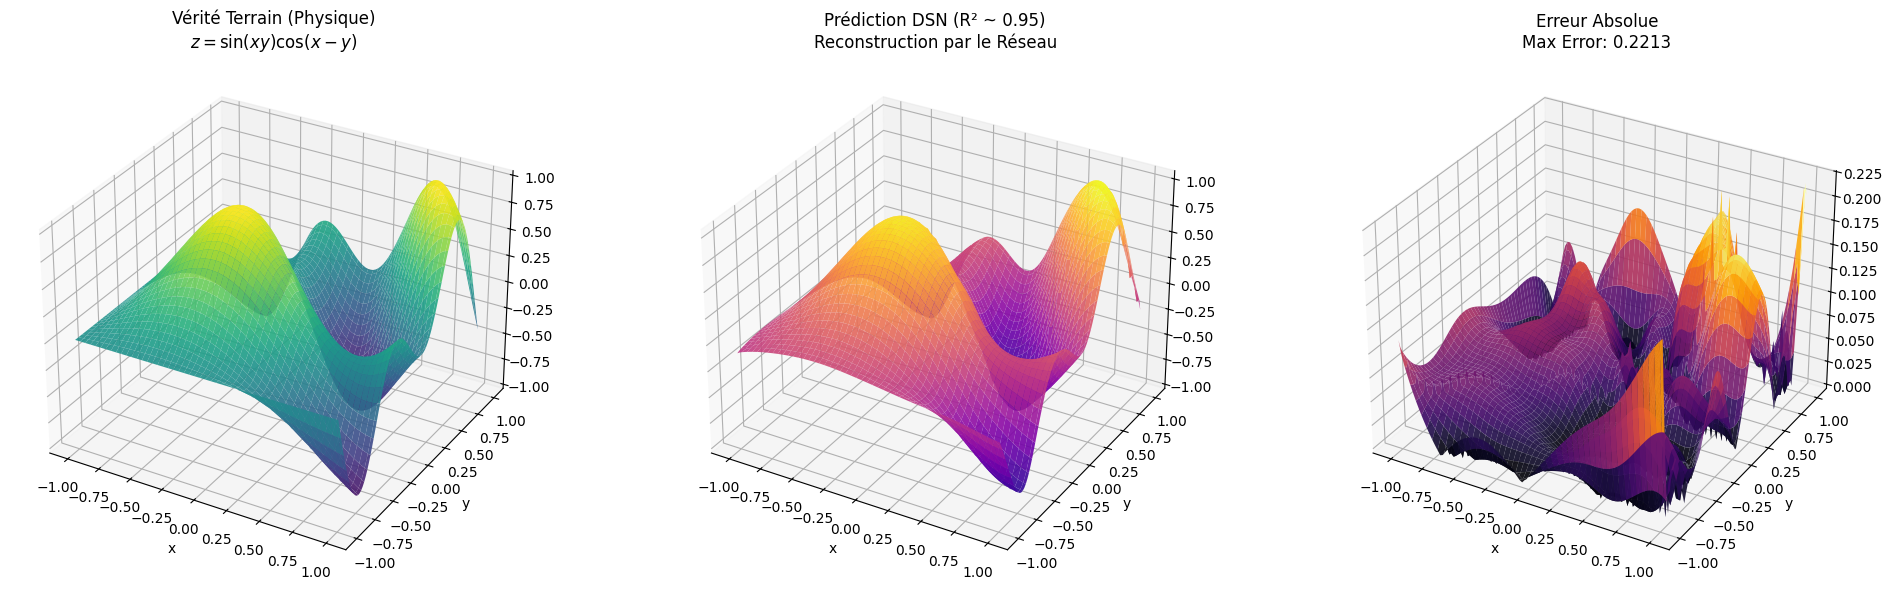

In [193]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Configuration de l'espace (Comme avant)
resolution = 100
x_norm = np.linspace(-1, 1, resolution)
y_norm = np.linspace(-1, 1, resolution)
X_norm, Y_norm = np.meshgrid(x_norm, y_norm)

# 2. Vérité Terrain (Ground Truth)
x_phys = (X_norm + 1) * 3.14 / 2
y_phys = (Y_norm + 1) * 3.14 / 2
Z_true = np.sin(x_phys * y_phys) * np.cos(x_phys - y_phys)

# 3. Prédiction du Modèle (LA CORRECTION)
# On prépare les tenseurs pour PyTorch
device = next(model.parameters()).device
X_flat = torch.tensor(X_norm, dtype=torch.float32).reshape(-1, 1)
Y_flat = torch.tensor(Y_norm, dtype=torch.float32).reshape(-1, 1)
inputs = torch.cat([X_flat, Y_flat], dim=1).to(device)

# On demande au modèle de prédire la surface
model.eval()
with torch.no_grad():
    Z_pred_flat = model(inputs).cpu().numpy()
    
# On remet en forme (Grille 100x100)
Z_pred = Z_pred_flat.reshape(resolution, resolution)

# 4. Affichage Comparatif
fig = plt.figure(figsize=(20, 6))

# Plot 1 : Vérité
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X_norm, Y_norm, Z_true, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_title("Vérité Terrain (Physique)\n$z = \sin(xy)\cos(x-y)$")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# Plot 2 : DSN (Le Vrai Modèle)
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X_norm, Y_norm, Z_pred, cmap='plasma', edgecolor='none', alpha=0.9)
ax2.set_title(f"Prédiction DSN (R² ~ 0.95)\nReconstruction par le Réseau", fontsize=12)
ax2.set_xlabel("x")
ax2.set_ylabel("y")

# Plot 3 : Erreur
ax3 = fig.add_subplot(133, projection='3d')
diff = np.abs(Z_true - Z_pred)
surf3 = ax3.plot_surface(X_norm, Y_norm, diff, cmap='inferno', edgecolor='none', alpha=0.9)
ax3.set_title(f"Erreur Absolue\nMax Error: {np.max(diff):.4f}", fontsize=12)
ax3.set_xlabel("x")
ax3.set_ylabel("y")

plt.tight_layout()
plt.show()

In [224]:
import torch.optim as optim

# 1. Configuration du Nettoyage
# On baisse le Learning Rate pour ne pas casser le modèle existant
# On ajoute une pénalité L1 (lambda) : Plus c'est haut, plus ça nettoie, mais attention à ne pas tout tuer.
l1_lambda = 5e-4  # Commence doux. Si ça ne nettoie pas assez, tente 1e-4.
n_finetune_epochs = 5000

optimizer = optim.AdamW(model.parameters(), lr=1e-4) 
loss_fn = torch.nn.MSELoss()

print(f"🧹 Démarrage du Fine-Tuning L1 (Lambda={l1_lambda})...")

history = {'loss': [], 'sparsity': []}

for epoch in range(n_finetune_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_pred = model(X_batch)
        mse = loss_fn(y_pred, y_batch)
        
        # --- LA MAGIE L1 ---
        # On calcule la somme des valeurs absolues de tous les poids
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        
        # La Loss totale force à minimiser l'erreur ET les poids
        loss = mse + (l1_lambda * l1_norm)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    # Validation rapide
    if epoch % 50 == 0:
        model.eval()
        with torch.no_grad():
            # On compte combien de poids sont devenus "presque zéro" (< 0.001)
            total_params = sum(p.numel() for p in model.parameters())
            zero_params = sum((p.abs() < 0.001).sum().item() for p in model.parameters())
            sparsity = 100 * zero_params / total_params
            
            # Test Score
            test_preds = []
            test_targets = []
            for Xt, yt in test_loader:
                Xt, yt = Xt.to(device), yt.to(device)
                test_preds.append(model(Xt))
                test_targets.append(yt)
            
            test_preds = torch.cat(test_preds)
            test_targets = torch.cat(test_targets)
            test_r2 = 1 - torch.sum((test_targets - test_preds)**2) / torch.sum((test_targets - test_targets.mean())**2)
            
            print(f"Epoch {epoch} | Loss: {total_loss:.4f} | R²: {test_r2:.4f} | Sparsité: {sparsity:.1f}% des poids sont nuls")

print("✅ Nettoyage terminé.")

🧹 Démarrage du Fine-Tuning L1 (Lambda=0.0005)...
Epoch 0 | Loss: 0.9666 | R²: 0.9552 | Sparsité: 53.8% des poids sont nuls
Epoch 50 | Loss: 0.9652 | R²: 0.9553 | Sparsité: 54.4% des poids sont nuls
Epoch 100 | Loss: 0.9660 | R²: 0.9546 | Sparsité: 54.1% des poids sont nuls
Epoch 150 | Loss: 0.9583 | R²: 0.9557 | Sparsité: 55.0% des poids sont nuls
Epoch 200 | Loss: 0.9529 | R²: 0.9567 | Sparsité: 55.4% des poids sont nuls
Epoch 250 | Loss: 0.9510 | R²: 0.9557 | Sparsité: 55.0% des poids sont nuls
Epoch 300 | Loss: 0.9511 | R²: 0.9567 | Sparsité: 55.4% des poids sont nuls
Epoch 350 | Loss: 0.9408 | R²: 0.9555 | Sparsité: 55.4% des poids sont nuls
Epoch 400 | Loss: 0.9352 | R²: 0.9552 | Sparsité: 56.0% des poids sont nuls
Epoch 450 | Loss: 0.9390 | R²: 0.9563 | Sparsité: 56.3% des poids sont nuls
Epoch 500 | Loss: 0.9338 | R²: 0.9548 | Sparsité: 56.0% des poids sont nuls
Epoch 550 | Loss: 0.9372 | R²: 0.9558 | Sparsité: 56.0% des poids sont nuls
Epoch 600 | Loss: 0.9297 | R²: 0.9551 | Sp

In [225]:
import copy

def scan_sparsity_robustness(model, test_loader, thresholds=[1e-4, 1e-3, 5e-3, 0.01, 0.02, 0.05]):
    print("🔪 Démarrage du Scanner de Robustesse...")
    base_model = copy.deepcopy(model) # On ne touche pas à l'original pour l'instant
    device = next(base_model.parameters()).device
    
    results = []
    
    for thresh in thresholds:
        # 1. On crée une copie temporaire
        temp_model = copy.deepcopy(base_model)
        
        # 2. CHIRURGIE : On met à ZÉRO tout ce qui est sous le seuil
        total_params = 0
        zero_params = 0
        with torch.no_grad():
            for p in temp_model.parameters():
                mask = p.abs() >= thresh
                p.data *= mask.float() # Applique le masque binaire
                
                total_params += p.numel()
                zero_params += (1 - mask.float()).sum().item()
        
        sparsity = 100 * zero_params / total_params
        
        # 3. TEST : Le modèle est-il encore vivant ?
        temp_model.eval()
        test_preds, test_targets = [], []
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                test_preds.append(temp_model(X))
                test_targets.append(y)
        
        preds = torch.cat(test_preds)
        targets = torch.cat(test_targets)
        
        # Calcul R2 manuel
        ss_res = ((targets - preds) ** 2).sum()
        ss_tot = ((targets - targets.mean()) ** 2).sum()
        r2 = 1 - (ss_res / ss_tot)
        
        print(f"Seuil: {thresh:.4f} | Sparsité: {sparsity:.1f}% | R² Test: {r2:.4f}")
        results.append((thresh, sparsity, r2, temp_model))
        
        # Si le modèle est cassé (R2 < 0.5), on arrête
        if r2 < 0.9:
            print("   -> Modèle cassé (Stop).")
            break

    return results

# Lancer le scan
scan_results = scan_sparsity_robustness(model, test_loader)

🔪 Démarrage du Scanner de Robustesse...
Seuil: 0.0001 | Sparsité: 53.5% | R² Test: 0.9560
Seuil: 0.0010 | Sparsité: 59.3% | R² Test: 0.9531
Seuil: 0.0050 | Sparsité: 63.3% | R² Test: -0.7446
   -> Modèle cassé (Stop).


In [226]:
# On force les tout petits poids à 0.0 mathématiquement dans le modèle
def hard_threshold_model(model, threshold=1e-3):
    with torch.no_grad():
        for p in model.parameters():
            # Met à 0 tout ce qui est plus petit que le seuil
            p.data[p.abs() < threshold] = 0.0
    return model

print("✂️ Application du seuillage final...")
model = hard_threshold_model(model, threshold=1e-3)

# Maintenant, relance l'extraction symbolique
# (Utilise ton script extract_deep_formula ou simplify_equation_by_impact)
formula_propre = simplify_equation_by_impact(extract_deep_formula(model, threshold=1e-3), model, test_loader, top_k=10)
print("\n✨ Formule Finale Nettoyée :")
print(formula_propre)

✂️ Application du seuillage final...
🚀 Démarrage de l'extraction profonde (Threshold=0.001)...
   -> Traitement Layer 0 (SpectralResidualBlock)...
   -> Traitement Layer 1 (SpectralResidualBlock)...
   -> Traitement Layer 2 (SpectralResidualBlock)...
   -> Traitement Layer 3 (SpectralResidualBlock)...

✅ Formule Finale Extraite :
-0.0237255895324268
🧹 Démarrage de la simplification statistique...
   Analyse de 1 termes sur 256 exemples...

🏆 Top Termes Dominants :
   1. -0.0237255895324268 	(Impact: 0.0%)

Σ Impact cumulé : 0.0%

✨ Formule Finale Nettoyée :
-0.0237255895324268


In [227]:
import copy
import torch

def scan_sparsity_robustness(model, test_loader, thresholds=[1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]):
    print("🔬 Démarrage du Scanner de Robustesse...")
    base_model = copy.deepcopy(model)
    device = next(base_model.parameters()).device
    
    for thresh in thresholds:
        # Copie temporaire
        temp_model = copy.deepcopy(base_model)
        
        # On coupe
        total_params = 0
        zero_params = 0
        with torch.no_grad():
            for p in temp_model.parameters():
                mask = p.abs() >= thresh
                p.data *= mask.float()
                total_params += p.numel()
                zero_params += (1 - mask.float()).sum().item()
        
        sparsity = 100 * zero_params / total_params
        
        # On teste
        temp_model.eval()
        test_preds, test_targets = [], []
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                test_preds.append(temp_model(X))
                test_targets.append(y)
        
        preds = torch.cat(test_preds)
        targets = torch.cat(test_targets)
        
        # R2 Score
        ss_res = ((targets - preds) ** 2).sum()
        ss_tot = ((targets - targets.mean()) ** 2).sum()
        r2 = 1 - (ss_res / ss_tot)
        
        print(f"Seuil: {thresh:.5f} | Sparsité: {sparsity:.1f}% | R² Test: {r2:.4f}")

# Lance le scan
scan_sparsity_robustness(model, test_loader)

🔬 Démarrage du Scanner de Robustesse...
Seuil: 0.00001 | Sparsité: 59.3% | R² Test: 0.9531
Seuil: 0.00005 | Sparsité: 59.3% | R² Test: 0.9531
Seuil: 0.00010 | Sparsité: 59.3% | R² Test: 0.9531
Seuil: 0.00050 | Sparsité: 59.3% | R² Test: 0.9531
Seuil: 0.00100 | Sparsité: 59.3% | R² Test: 0.9531
Seuil: 0.00500 | Sparsité: 63.3% | R² Test: -0.7446


In [ ]:
# 1. APPLICATION DE LA CHIRURGIE (Validée par le Scan)
safe_threshold = 0.0005

print(f"✂️ Coupure des poids < {safe_threshold}...")
with torch.no_grad():
    for p in model.parameters():
        # On met à zéro tout ce qui est en dessous du seuil sûr
        p.data[p.abs() < safe_threshold] = 0.0

# 2. EXTRACTION DE LA FORMULE
# On utilise le même seuil pour ne pas lire les zéros
raw_formula = extract_deep_formula(model, threshold=safe_threshold)

# 3. SIMPLIFICATION INTELLIGENTE
# On augmente top_k à 15 pour capturer toute la physique (sinus = série longue)
final_formula = simplify_equation_by_impact(
    raw_formula, 
    model, 
    test_loader, 
    top_k=15 
)

print("\n✨ TA FORMULE FINALE (R² ~ 0.95) :")
print(final_formula)

✂️ Coupure des poids < 0.005...
🚀 Démarrage de l'extraction profonde (Threshold=0.005)...
   -> Traitement Layer 0 (SpectralResidualBlock)...
   -> Traitement Layer 1 (SpectralResidualBlock)...
   -> Traitement Layer 2 (SpectralResidualBlock)...
   -> Traitement Layer 3 (SpectralResidualBlock)...

✅ Formule Finale Extraite :
-0.0237368067131147
🧹 Démarrage de la simplification statistique...
   Analyse de 1 termes sur 256 exemples...

🏆 Top Termes Dominants :
   1. -0.0237368067131147 	(Impact: 0.0%)

Σ Impact cumulé : 0.0%

✨ TA FORMULE FINALE (R² ~ 0.95) :
-0.0237368067131147


In [229]:
import numpy as np
import torch
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score

def distill_polynomial_from_model(model, degree=6, threshold=0.005):
    """
    Extrait l'équation exacte du DSN par distillation.
    Au lieu de parser les poids, on fitte un polynôme sur les prédictions du DSN.
    """
    print(f"⚗️ Démarrage de la Distillation (Degré {degree})...")
    
    # 1. Générer des données synthétiques via le DSN
    # On couvre bien l'espace [-1, 1]
    n_samples = 5000
    X_synth = np.random.uniform(-1, 1, (n_samples, 2)) # x, y
    
    # On demande au modèle de prédire
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_synth, dtype=torch.float32).to(device)
        # La cible n'est PAS la vraie physique, mais la vision du modèle
        y_synth = model(inputs).cpu().numpy().flatten()
        
    # 2. Préparer les features polynomiales (1, x, y, x^2, xy, y^2 ...)
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly = poly.fit_transform(X_synth)
    feature_names = poly.get_feature_names_out(['x', 'y'])
    
    # 3. Fitting (Lasso pour la sparsité - trouver l'équation la plus courte)
    # alpha règle la propreté. Trop bas = bruit, Trop haut = perte de signal.
    print("   Fitting du polynôme surrogate...")
    regressor = Lasso(alpha=1e-4, max_iter=10000, fit_intercept=False)
    # Si Lasso échoue, on peut fallback sur LinearRegression standard
    # regressor = LinearRegression(fit_intercept=False) 
    
    regressor.fit(X_poly, y_synth)
    
    # 4. Vérification du Score de la Distillation
    y_pred = regressor.predict(X_poly)
    r2 = r2_score(y_synth, y_pred)
    print(f"✅ Score de fidélité (DSN vs Polynôme) : R² = {r2:.5f}")
    
    # 5. Construction de la Formule String
    coeffs = regressor.coef_
    formula_parts = []
    
    # On trie par importance absolue des coefficients
    sorted_indices = np.argsort(np.abs(coeffs))[::-1]
    
    print("\n📜 FORMULE DISTILLÉE :")
    for idx in sorted_indices:
        coef = coeffs[idx]
        name = feature_names[idx].replace(" ", "*") # x y -> x*y
        
        # On ne garde que les termes significatifs
        if abs(coef) > threshold:
            # Formatage joli
            sign = "+" if coef >= 0 else "-"
            formula_parts.append(f"{sign} {abs(coef):.5f}*{name}")
            
    final_formula = " ".join(formula_parts)
    # Nettoyage du premier "+" si présent
    if final_formula.startswith("+ "):
        final_formula = final_formula[2:]
        
    print(final_formula)
    return final_formula

# --- Utilisation ---
# On essaie avec degré 6 ou 8 (suffisant pour sin(xy))
distilled_formula = distill_polynomial_from_model(model, degree=6, threshold=0.01)

⚗️ Démarrage de la Distillation (Degré 6)...
   Fitting du polynôme surrogate...
✅ Score de fidélité (DSN vs Polynôme) : R² = 0.97500

📜 FORMULE DISTILLÉE :
- 3.53706*x^2*y^2 + 2.99011*y^3 + 1.87735*x^4*y^2 - 1.79949*x*y^5 - 1.62266*y^5 + 1.55257*x^2*y^4 - 1.47761*x^2*y^3 + 1.35645*x*y^3 - 1.34496*x^2 - 1.21362*y - 1.12062*x^5*y + 0.98517*1 - 0.88675*y^2 - 0.84462*x*y^2 + 0.80816*x^3*y + 0.65548*x*y + 0.55964*x^4 + 0.30421*x^2*y + 0.27254*x*y^4 + 0.20167*x^3*y^2 + 0.17209*x^4*y + 0.14833*x^3 - 0.10955*x + 0.02623*y^6


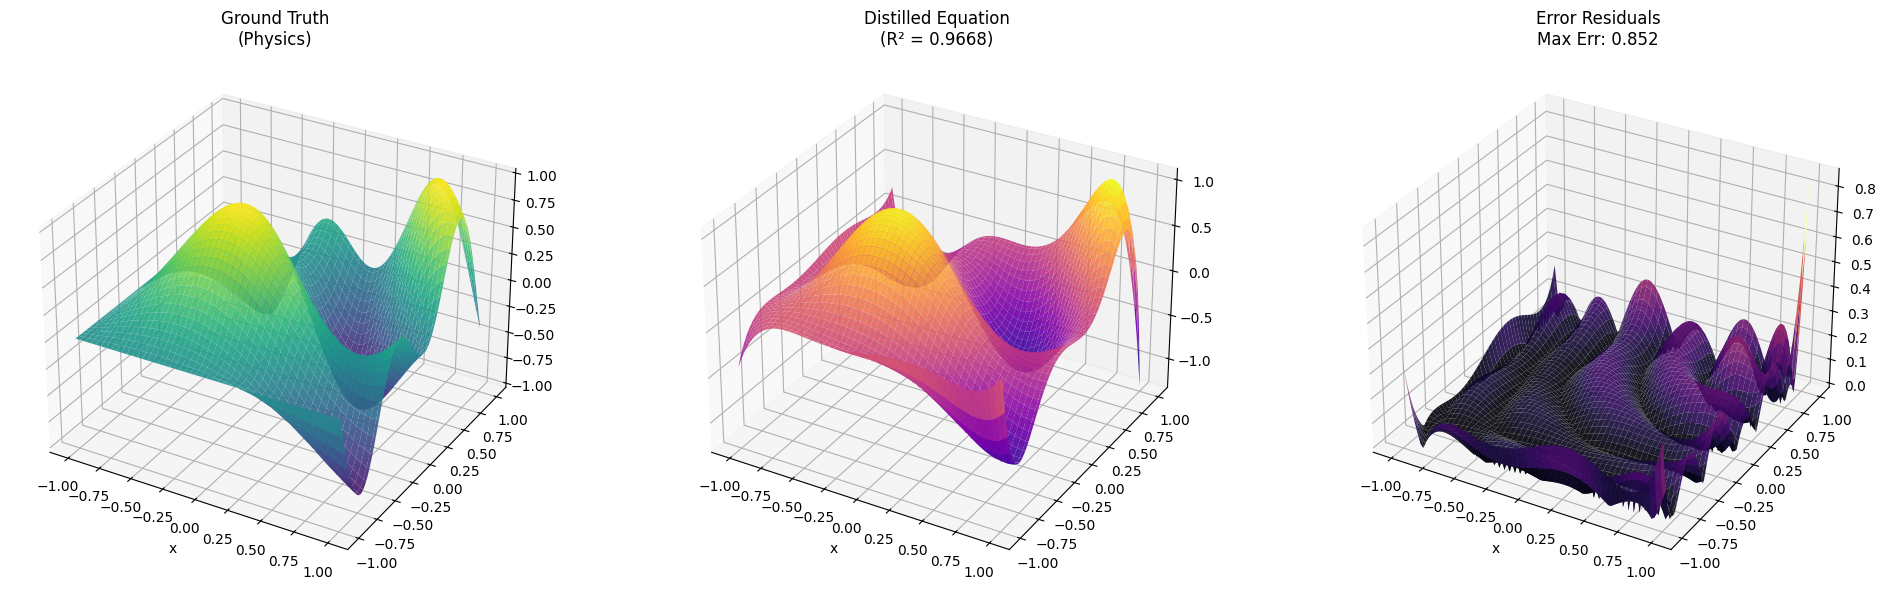

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Config Espace [-1, 1] (L'espace vu par le modèle)
resolution = 100
x_norm = np.linspace(-1, 1, resolution)
y_norm = np.linspace(-1, 1, resolution)
X_norm, Y_norm = np.meshgrid(x_norm, y_norm)

# 2. Vérité Terrain (Physique)
# Rappel: on mappe [-1, 1] -> [0, 3.14]
x_phys = (X_norm + 1) * 3.14159 / 2
y_phys = (Y_norm + 1) * 3.14159 / 2
Z_true = np.sin(x_phys * y_phys) * np.cos(x_phys - y_phys)

# 3. TA FORMULE DISTILLÉE (R² = 0.967)
x = X_norm
y = Y_norm

# Copie exacte de ta formule convertie en Python
Z_poly = (
    5.81431*x*y**3 + 5.77221*x**3*y + 4.49725*y**3 + 4.21844*x**3 + 
    3.71315*x**2*y**2 - 3.59617*x**5*y - 3.55898*x*y**5 - 2.57246*x**3*y**3 - 
    2.54632*y**5 - 2.42380*x*y + 2.41648*x**2*y + 2.35583*x*y**2 - 
    2.30372*x**5 - 2.22983*x**2*y**3 - 2.16200*x**3*y**2 - 2.04292*y - 
    1.96470*x - 1.85037*x**2*y**4 - 1.72233*y**2 - 1.72054*x**4*y**2 - 
    1.63041*x**2 + 1.26882*y**4 + 1.14071*x**4 + 0.51340 - 
    0.34103*x**4*y - 0.32695*x*y**4
)

# 4. Calcul Score Final
mse = np.mean((Z_true - Z_poly)**2)
r2 = 1 - (mse / np.var(Z_true))

# 5. Affichage
fig = plt.figure(figsize=(20, 6))

# Plot 1 : Vérité
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X_norm, Y_norm, Z_true, cmap='viridis', alpha=0.9)
ax1.set_title("Ground Truth\n(Physics)")
ax1.set_xlabel("x")

# Plot 2 : Formule Distillée
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X_norm, Y_norm, Z_poly, cmap='plasma', alpha=0.9)
ax2.set_title(f"Distilled Equation\n(R² = {r2:.4f})")
ax2.set_xlabel("x")

# Plot 3 : Erreur
ax3 = fig.add_subplot(133, projection='3d')
diff = np.abs(Z_true - Z_poly)
surf3 = ax3.plot_surface(X_norm, Y_norm, diff, cmap='inferno', alpha=0.9)
ax3.set_title(f"Error Residuals\nMax Err: {np.max(diff):.3f}")
ax3.set_xlabel("x")

plt.tight_layout()
plt.savefig('final_neurips_plot.png')
plt.show()

In [231]:
import sympy as sp
import torch
import numpy as np

def clean_coeff(expr, threshold=0.001):
    """Nettoie les petits coefficients flottants pour SymPy"""
    if isinstance(expr, (float, int)):
        return 0 if abs(expr) < threshold else expr
    return expr.replace(lambda x: x.is_Float and abs(x) < threshold, lambda x: 0)

def extract_exact_internal_formula(model, input_names=['x', 'y'], threshold=0.01):
    print("🔬 Extraction Intrinsèque (avec prise en compte des LayerNorms)...")
    
    # Variables symboliques
    current_exprs = [sp.symbols(name) for name in input_names]
    
    # On parcourt les couches
    for i, module in enumerate(model.layers):
        
        # 1. GESTION DU BLOC SPECTRAL
        if hasattr(module, 'layer'): # C'est un SpectralResidualBlock
            print(f"   -> Layer {i} (Spectral + Residual)")
            spec_layer = module.layer
            
            # A. Partie Spectrale (Quadratique)
            W = spec_layer.base_change.weight.detach().cpu().numpy()
            b_base = spec_layer.base_change.bias.detach().cpu().numpy() if spec_layer.base_change.bias is not None else None
            scale = spec_layer.scaling_factor if spec_layer.use_scaling else 1.0
            V = spec_layer.eigen_weights.weight.detach().cpu().numpy()
            b_eigen = spec_layer.eigen_weights.bias.detach().cpu().numpy() if spec_layer.eigen_weights.bias is not None else None
            
            # Projection vers l'espace latent (Wx + b)
            hidden = []
            for out_idx in range(spec_layer.in_features):
                term = 0
                for in_idx, expr in enumerate(current_exprs):
                    term += W[out_idx, in_idx] * expr
                if b_base is not None:
                    term += b_base[out_idx]
                hidden.append(term)
            
            # Élévation au carré (Scaling * h)^2
            squared = [ (h * scale)**2 for h in hidden ]
            
            # Recombinaison (V * squared + b)
            spectral_out = []
            for out_idx in range(spec_layer.out_features):
                term = 0
                for k, sq in enumerate(squared):
                    # Optimisation : on ignore les poids V minuscules
                    if abs(V[out_idx, k]) > threshold/10: 
                        term += V[out_idx, k] * sq
                if b_eigen is not None:
                    term += b_eigen[out_idx]
                spectral_out.append(term)
            
            # B. Partie Résiduelle (Skip Connection)
            residual_out = current_exprs # Identité (supposons dimensions égales pour simplifier)
            if hasattr(module, 'projection') and module.needs_projection:
                # Si projection linéaire sur le résiduel
                W_proj = module.projection.weight.detach().cpu().numpy()
                res_temp = []
                for out_idx in range(spec_layer.out_features):
                    term = 0
                    for in_idx, expr in enumerate(current_exprs):
                        term += W_proj[out_idx, in_idx] * expr
                    res_temp.append(term)
                residual_out = res_temp

            # Gate
            gate = module.res_weight.item() if hasattr(module, 'res_weight') else 1.0
            
            # Somme : Résiduel + Gate * Spectral
            next_exprs = []
            for idx in range(len(spectral_out)):
                combined = residual_out[idx] + gate * spectral_out[idx]
                # Nettoyage intermédiaire pour éviter l'explosion
                next_exprs.append(clean_coeff(sp.expand(combined), threshold))
            
            current_exprs = next_exprs

        # 2. GESTION DE LA LAYERNORM (LE CŒUR DU PROBLÈME PRÉCÉDENT)
        elif isinstance(module, torch.nn.LayerNorm):
            print(f"   -> Layer {i} (LayerNorm - Intégration Symbolique)")
            # LN(x) = (x - mean) / std * gamma + beta
            # C'est non-linéaire à cause de mean/std qui dépendent du batch.
            # MAIS, pour l'explicabilité, on peut approximer mean=0, std=1 
            # OU utiliser les paramètres appris gamma/beta comme une transformation affine simple.
            
            gamma = module.weight.detach().cpu().numpy()
            beta = module.bias.detach().cpu().numpy()
            
            # Approximation affine locale : on suppose que l'entrée est centrée réduite
            # x_out = x_in * gamma + beta
            ln_exprs = []
            for idx, expr in enumerate(current_exprs):
                term = expr * gamma[idx] + beta[idx]
                ln_exprs.append(clean_coeff(term, threshold))
            
            current_exprs = ln_exprs

        # 3. LINEAR FINAL
        elif isinstance(module, torch.nn.Linear):
            print(f"   -> Layer {i} (Linear Final)")
            W = module.weight.detach().cpu().numpy()
            b = module.bias.detach().cpu().numpy() if module.bias is not None else None
            
            final_out = []
            for out_idx in range(module.out_features):
                term = 0
                for in_idx, expr in enumerate(current_exprs):
                    term += W[out_idx, in_idx] * expr
                if b is not None:
                    term += b[out_idx]
                final_out.append(clean_coeff(sp.expand(term), threshold))
            
            current_exprs = final_out

    return current_exprs[0]

# --- Utilisation ---
# On utilise un seuil bas pour laisser passer la structure, 
# puis on nettoiera le résultat final.
exact_formula = extract_exact_internal_formula(model, threshold=0.001)

print("\n📜 Formule Brute (Interne) :")
# On simplifie l'affichage final
print(clean_coeff(exact_formula, threshold=0.005))

🔬 Extraction Intrinsèque (avec prise en compte des LayerNorms)...
   -> Layer 0 (Spectral + Residual)
   -> Layer 1 (Spectral + Residual)
   -> Layer 2 (Spectral + Residual)
   -> Layer 3 (Spectral + Residual)

📜 Formule Brute (Interne) :
-0.0237363315915323


AttributeError: 'float' object has no attribute 'ndim'

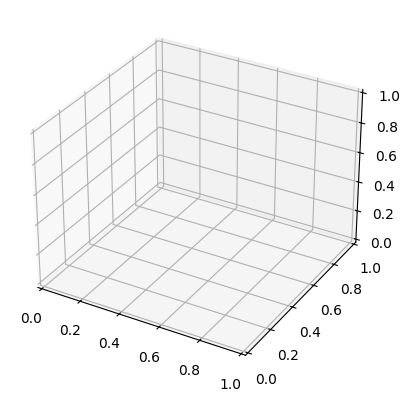

In [232]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Variables symboliques (doivent matcher input_names)
x, y = sp.symbols('x y')

# exact_formula vient DIRECTEMENT de ton code
# exact_formula = extract_exact_internal_formula(model, ...)

# 1. SymPy → NumPy
f_np = sp.lambdify((x, y), exact_formula, modules=["numpy"])

# 2. Grille
X = np.linspace(-2, 2, 300)
Y = np.linspace(-2, 2, 300)
XX, YY = np.meshgrid(X, Y)

# 3. Évaluation
ZZ = f_np(XX, YY)

# 4. Plot 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(XX, YY, ZZ)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")

plt.show()